<a href="https://colab.research.google.com/github/DmitryBugauchuk/Blog-Examples/blob/master/ManFemaleDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Здравствуйте! Цель второго задания - Необходимо обучить нейросеть, способную по входному изображению лица
определять пол человека на изображении. Буду честен - с pytorch я не особо знаком, так как практиковался в основном с помощью tensoflow, но перекопав сайт pytorch, мануалы и частично kaggle смог создать нейросесть для определения пола человека. 
Приятного прсомтра!
---



Первое задание

In [46]:
  
def mssl(x):
    best = cur = 0
    curi = starti = besti = 0
    for ind, i in enumerate(x):
        if cur+i>0:
            cur +=i
        else:
            cur, curi = 0, ind+1
        if cur>best:
            starti, besti, best = curi, ind+1, cur
    return  best, x[starti:besti]

mssl([4, -2, -8, 5, -2, 7, 7, 2, -6, 5])

(19, [5, -2, 7, 7, 2])

Второе задание

In [1]:
import zipfile
import os
import time
 
from google.colab import drive
from PIL import Image

Перед тем как загрузить данные на google drive, я разделил все по папкам test, train, val для удобства и заархивировал их в zipfile для того чтобы загрузить быстрее файлы в google drive.

In [13]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
zip_file = '/content/gdrive/My Drive/images.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir())

['.config', 'val', 'train', 'test', 'gdrive', 'sample_data']


In [15]:
%pwd

'/content'

In [16]:
%ls

gdrive/  sample_data/  test/  train/  val/


In [17]:
!fusermount -u drive
!google-drive-ocamlfuse drive

fusermount: failed to unmount /content/drive: No such file or directory
/bin/bash: google-drive-ocamlfuse: command not found


In [18]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [19]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

Прописываю пути к файлам и отображаю их

In [22]:
DATA_DIR = '/content/'

In [24]:
TRAIN_DIR = DATA_DIR + '/train'                           
TEST_DIR = DATA_DIR + '/test'     
VAL_DIR = DATA_DIR + '/val'

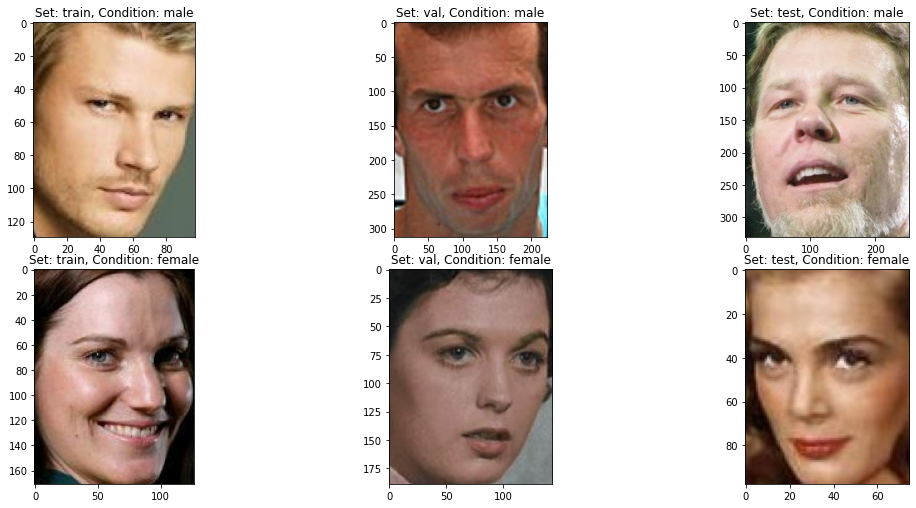

In [25]:
input_path = '/content/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/male/'+os.listdir(set_path+'/male')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: male'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/female/'+os.listdir(set_path+'/female')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: female'.format(_set))

Здесь провожу агументацию изображений только для train выборки и преобразую в тензоры  все выборки.

In [26]:
image_transforms = {
    'train':
    T.Compose([
        T.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        T.RandomRotation(degrees=15),
        T.ColorJitter(),
        T.RandomHorizontalFlip(),
        T.CenterCrop(size=224),  
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ]),
    'val':
    T.Compose([
        T.Resize(size=256),
        T.CenterCrop(size=224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    T.Compose([
        T.Resize(size=256),
        T.CenterCrop(size=224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [27]:
train_ds = ImageFolder(root=TRAIN_DIR, transform=image_transforms['train'])
valid_ds = ImageFolder(root=VAL_DIR, transform=image_transforms['val'])
test_ds = ImageFolder(root=TEST_DIR, transform=image_transforms['test'])
len(train_ds), len(valid_ds), len(test_ds)

(97802, 200, 2000)

In [28]:
train_ds

Dataset ImageFolder
    Number of datapoints: 97802
    Root location: /content//train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=(-15, 15), resample=False, expand=False)
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Проверяю классы

In [29]:
print("Classes:")
class_names = train_ds.classes
print(class_names)

Classes:
['female', 'male']


In [30]:
batch_size = 64

Использую DataLoader для пакетирования данных и перемешивания.

In [31]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


target 0
Labels: female(0)


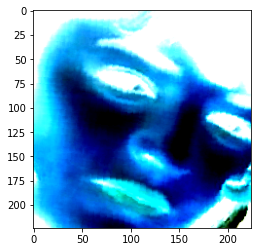

In [32]:
def show_image(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:1], nrow=8).permute(1, 2, 0))
        break

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    if isinstance(target, int):
        result.append(class_names[target] + "(" + str(target) + ")")
    else:
        
        for i, x in enumerate(target):
            if (x >= threshold):
                if text_labels:
                    result.append(class_names[i] + "(" + str(i) + ")")
                else:
                    result.append(str(i))
    return ' '.join(result)

def show_sample(img, target, invert=True):
    print("target", target)
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))
        

        

show_sample(*train_ds[2000])

Функция для использования GPU. На моем компьютере проблемы c видеокартой и используется процессор - что заняло бы много времени для создания нейросети, поэтому я использую мощности google colab. 

In [33]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [34]:
device = get_default_device()
device

device(type='cuda')

In [35]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Модель

In [36]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
 
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Предсказывает
        loss = F.cross_entropy(out, labels) # Вычислении потерь
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Предсказывает
        loss = F.cross_entropy(out, labels)   # Вычисление потерь
        acc = accuracy(out, labels)           # Вычисление точности
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Объединение потерь по средней 
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Объединение точности по среденй
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [37]:
resnet18 = models.resnet18()
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
class MaleFemaleResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet18(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    

In [39]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Настройка оптимизатора с уменьшением ыеса
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Настройка скорости обучения
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs): 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Отсечния градиента
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Запись и обновление скорости обучения
            lrs.append(get_lr(optimizer))
            sched.step()
        

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [41]:
model = to_device(MaleFemaleResnet(), device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [42]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.2643229365348816, 'val_loss': 2.270599603652954}]

In [43]:
model.freeze()

Гиперпараметры для модели

In [44]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00280, train_loss: 1.5055, val_loss: 1.4858, val_acc: 0.9588
Epoch [1], last_lr: 0.00760, train_loss: 1.5165, val_loss: 1.5010, val_acc: 0.9579
Epoch [2], last_lr: 0.01000, train_loss: 1.5160, val_loss: 1.5271, val_acc: 0.8976
Epoch [3], last_lr: 0.00950, train_loss: 1.5093, val_loss: 1.5334, val_acc: 0.8945
Epoch [4], last_lr: 0.00812, train_loss: 1.5058, val_loss: 1.5322, val_acc: 0.9062
Epoch [5], last_lr: 0.00611, train_loss: 1.5022, val_loss: 1.5274, val_acc: 0.9102
Epoch [6], last_lr: 0.00389, train_loss: 1.4989, val_loss: 1.4944, val_acc: 0.9705
Epoch [7], last_lr: 0.00188, train_loss: 1.4939, val_loss: 1.4861, val_acc: 0.9774
Epoch [8], last_lr: 0.00050, train_loss: 1.4894, val_loss: 1.4786, val_acc: 0.9627
Epoch [9], last_lr: 0.00000, train_loss: 1.4865, val_loss: 1.4796, val_acc: 0.9696
CPU times: user 10min 39s, sys: 3min 38s, total: 14min 17s
Wall time: 1h 57s


In [ ]:
def plot_scores(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

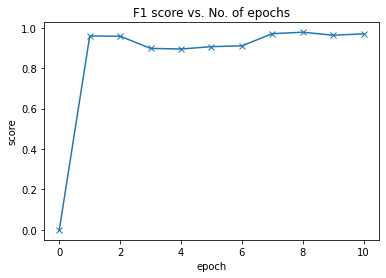

In [ ]:
plot_scores(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

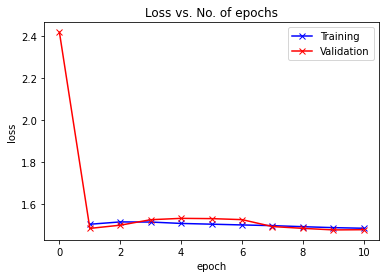

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

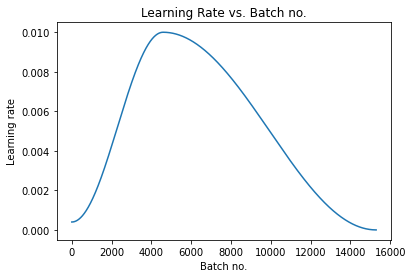

In [ ]:
plot_lrs(history)

In [ ]:
def predict_x_ray(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [ ]:
img, target = test_ds[0]
img.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:  tensor([1.4618e-06, 1.0000e+00, 2.0842e-04, 2.0836e-04, 2.0834e-04, 2.0841e-04,
        2.0838e-04, 2.0837e-04, 2.0842e-04, 2.0842e-04], device='cuda:0',
       grad_fn=<SelectBackward>)
target tensor([1.4618e-06, 1.0000e+00, 2.0842e-04, 2.0836e-04, 2.0834e-04, 2.0841e-04,
        2.0838e-04, 2.0837e-04, 2.0842e-04, 2.0842e-04], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: male(1)


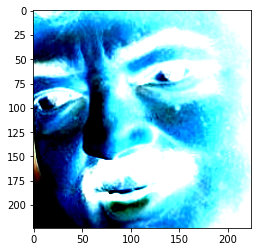

In [ ]:
predict_x_ray(test_ds[1400][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:  tensor([9.9999e-01, 6.2411e-02, 2.3637e-04, 2.3643e-04, 2.3643e-04, 2.3638e-04,
        2.3641e-04, 2.3641e-04, 2.3636e-04, 2.3636e-04], device='cuda:0',
       grad_fn=<SelectBackward>)
target tensor([9.9999e-01, 6.2411e-02, 2.3637e-04, 2.3643e-04, 2.3643e-04, 2.3638e-04,
        2.3641e-04, 2.3641e-04, 2.3636e-04, 2.3636e-04], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: female(0)


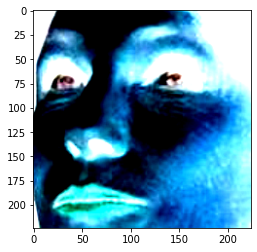

In [ ]:
predict_x_ray(test_ds[500][0])

In [ ]:
print("Сохраняем сеть")
torch.save(model.state_dict(), 'content')

Сохраняем сеть


Я очень извиняюсь,но я не успел сохранить модель согласно заданию (не хватило одного дня). Сначала я разбил данные вручную на val, train, test. Привеk данные к определенному виду ипровел агументацию train. Использовал для обучения resnet.